In [1]:
#import nessesary packages 
import pandas as pd
import numpy as np
from statistics import *
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import contractions
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, f1_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix as pcm
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, auc
import matplotlib
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
#set panda settings to display all data untruncated 
pd.set_option('display.max_colwidth', -1)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [3]:
#read scraped raw data 
data = pd.read_json('clothingreviewdata.json')

In [4]:
data.shape

(8499, 3)

In [5]:
data[3000:3005]

,star,title,review
3000,1 star: Bad,"Awful awful awful, do not shop here","[\n Clothes unfortunately didn't fit - tried to get a refund for them and it took them ages to get back to me. Had to go through PayPal and they STILL wouldn't give me a full refund even though I did exactly as they said and posted the products back to them with tracked shipping. In the end, I had sent back all products, and Zaful got to keep my money too. Completely unfair and disgusting. , UPDATE: Turns out they trick you into sending their clothes to their Spain warehouse and then say that they never received it and that it should have gone to their China warehouse. So, if you ever need to return anything MAKE SURE YOU SCREENSHOT EVERY CONVERSATION! They slipped up and mentioned the Spain warehouse address in our Paypal conversation luckily so I managed to win my case but they were adamant that they only specified their China warehouse when they definitely didn't. Liars and scammers.\n ]"
3001,5 stars: Excellent,ZAFUL Purchase,"[\n I have mainly purchased sweatshirts and bikinis from zaful and i love them! The sweatshirts came in very nice quality and looked exactly like the pictures. I also ordered 3 bikinis, 2 of them fit perfectly and are some of my favorites. The low prices are great for what you get. One bikini did not fit me as well but i believe i ordered the wrong size. It is really helpful that they have customer reviews with pictures to see how they look on person and to see what size will fit you best.\n ]"
3002,5 stars: Excellent,Swimwear Galore,[\n Zaful has a great variety of swimwear and I love shopping with them because they have great pricing for their sets. The swimwear is very good quality and I am likely to find something unique and bikini cut from their site\n ]
3003,5 stars: Excellent,Highly recommend Zaful!,"[\n I have had really good experiences with Zaful in the past. I have bought multiple bathing-suits from this site and I have been very happy with the quality and price of their products. They are also very efficient with answering questions and giving refunds when necessary. , I would recommend Zaful to anyone looking for affordable trendy clothes!\n ]"
3004,4 stars: Great,My first choice!,"[\n I love shopping on zaful for several reasons! In my opinion is an excellent site for those who want quite affordable products, with an excellent quality / price, those looking for products that are not in common stores and with a very modern models! It is a safe and practical website with an excellent team that solves any problem with orders, doubts, etc., very quickly!\n ]"


In [6]:
#clean "star" column of data frame and split string at each word 
data['star'] = (data['star']).astype(str)
data['star'] = data['star'].replace('\s+', ' ')
data['star'] = data['star'].str.split(' ')

In [7]:
#create empty "unsatisfied" data column 
data['unsatisfied'] = ''

#recode data to populated "unsatisfied" column based on number of stars reviewers gave
for i in range(len(data)):
    if data['star'][i][0] == '5':
        data['unsatisfied'][i] = 0
    elif data['star'][i][0] == '1' or  data['star'][i][0] == '2':
        data['unsatisfied'][i] = 1
    else:
        data['unsatisfied'][i] = np.NaN

In [8]:
#clean up text from "review" column on data frame and split string at each word
data['review'] = (data['review']).astype(str)
data['review'] = data['review'].str.replace('\s+', ' ')
data['review'] = data['review'].str.lower()
translator = str.maketrans('', '', string.punctuation)
data['review'] = data['review'].str.translate(translator)
data['review'] = data['review'].str.strip('n ')
data['review'] = data['review'].str.split(' ')

In [9]:
#drop data without sufficent text and data where reviews gave mid-teir reviews (3 or 4 stars)
data = data[data['review'].map(lambda x: len(x)) > 1] 
data = data.dropna(subset = ['unsatisfied'])
data = data[['star', 'review', 'unsatisfied']]
data = data.reset_index(drop=True)
data['unsatisfied'] = data['unsatisfied'].astype(int)

In [10]:
#expand contractions in text
data['review'] = data['review'].apply(lambda x: [contractions.fix(y) for y in x])

In [11]:
#lemmatize text
stemmer = WordNetLemmatizer()

data['review'] = data['review'].apply(lambda x: [stemmer.lemmatize(y, 'v') for y in x])
data['review'] = data['review'].apply(lambda x: [stemmer.lemmatize(y, 'n') for y in x])

In [12]:
#correct misspellings in text
spell = SpellChecker(distance=1)

for i in data.index:
    data['review'][i]=[spell.correction(word) for word in data['review'][i]]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
#rejoin text
for i in range(len(data)):
    data['review'][i] =' '.join([str(elem) for elem in data['review'][i]]) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
for i in range(len(data)):
    data['star'][i] =' '.join([str(elem) for elem in data['star'][i]]) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
data.shape

(6749, 3)

In [16]:
#save cleaned data as json file
data.to_json('clothingreviewdata_cleaned.json')
data[3000:3005]

,star,review,unsatisfied
3000,5 stars: Excellent,zaful be a great site to order bath suit on affordable and cute you will see the same bath suit on different sit that be way more expensive such a good bargain and if you actually do have problem with size or just the product itself they be super fast at get back to you and resolve the problem ship be awesome i think it would take week but i receive my care package within a week,0
3001,1 star: Bad,zaful be absolutely horrible they be cheaper and stammer they be very disorganized and will not even ship an item you order i order two swimsuit and never receive the second one they keep send me order receipt of my first one claim i received it but i never do they continue to misread my email and never let me speak to a supervisor lead me to believe they be a complete scam they basically steal my money and tell me to reorder the swimsuit for a higher price a i pay for it when it be on sale never buy from here,1
3002,5 stars: Excellent,at first i be a little skeptical but after watch youtube haul of people purchase clothe and try it on it seem pretty legit in the past 2 month i have make 4 order with zaful and be extremely please with everything i have received all of my order have be deliver in 710 day and all of the clothe have be exactly like the picture and fit well by far the bikini be my favourite purchase i have purchase 4 the customer service be really great too i want to return a dress because it did not fit quite right and zaful be kindly enough to let me keep the dress and full refund my money they also get back to me within the hour and be very kind and generous zaful have become my new favourite online shop store and i highly recommend i recommend do your research first and purchase thing that people on youtube have buy too and work well for them if there is one thing you take away from this review be that zafuls bikini be really great quality and amaze for the price consider how expensive bikini be get now in store if you want to give zaful a shoot buy a cute bikini you will be happily surprise,0
3003,1 star: Bad,worst order in my life of online shop spend about 200euro on awful clothe material be the cheapest of all time some of the clothe were not even stitch properly literal thread come out of the side of the dress etc a i find 1 playsuit that be wearable out of many though once i put it on for one basic wash it shrink to half it size honestly if i could warn everyone never ever buy from zaful,1
3004,1 star: Bad,i order 5 bikini at once in late may and i still have nots get them in mid august i contact zaful customer service and they did not help me out at all the track say my order arrive but i never get any package it have be almost three month i want the bikini i spend money o,1


In [17]:
#count vectorize top 2000 most common words in sets or 1 to 2 words
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=10, max_df=2000)
X_cv = cv.fit_transform(data['review'])

In [18]:
#create train-test split in dataset
X_train, X_test, y_train, y_test = train_test_split(X_cv, data['unsatisfied'], test_size=0.25, random_state=0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5061, 4249) (5061,)
Test set: (1688, 4249) (1688,)


In [19]:
#apply Naive Bayes classifier to fit model on train dataset and predict on test dataset
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
naive_bayes_predictions = naive_bayes.predict(X_test)
naive_bayes_prob = naive_bayes.predict_proba(X_test)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9814    0.9787    0.9800      1079
Unsatisfied (1)     0.9624    0.9672    0.9648       609

       accuracy                         0.9745      1688
      macro avg     0.9719    0.9729    0.9724      1688
   weighted avg     0.9746    0.9745    0.9745      1688

Naive Bayes Accuracy: 0.9745260663507109
Naive Bayes Jaccard: 0.9319620253164557
Naive Bayes Log_Loss: 0.212767592516965


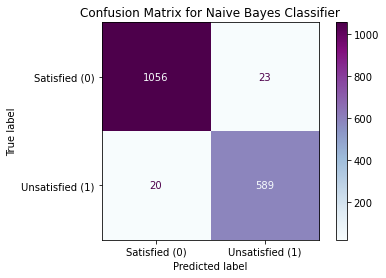

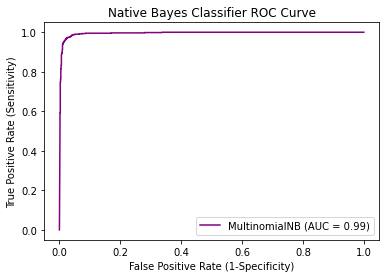

In [20]:
#create classificaton report
print (classification_report(y_test, naive_bayes_predictions, labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
#create confusion matrix
display = pcm(naive_bayes, X_test, y_test, display_labels=['Satisfied (0)', "Unsatisfied (1)"], cmap='BuPu')
display.ax_.set_title('Confusion Matrix for Naive Bayes Classifier')

#create ROC plot
plt = plot_roc_curve(naive_bayes, X_test, y_test, color="purple")  
plt.ax_.set_title('Native Bayes Classifier ROC Curve')
plt.ax_.set_xlabel('False Positive Rate (1-Specificity)')
plt.ax_.set_ylabel('True Positive Rate (Sensitivity)')

#other Naive Bayes classifier evaluation scores 
print('Naive Bayes Accuracy:', (accuracy_score(y_test, naive_bayes_predictions)))
print('Naive Bayes Jaccard:', (jaccard_score(y_test, naive_bayes_predictions, pos_label=1, average='binary')))
print('Naive Bayes Log_Loss:', (log_loss(y_test, naive_bayes_prob)))

In [21]:
#apply SVM classifier to fit model on train dataset and predict on test dataset
SVM = SVC(kernel='rbf', probability=True, )
SVM.fit(X_train, y_train)
SVM_predictions = SVM.predict(X_test)
SVM_prob = SVM.predict_proba(X_test)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9849    0.9657    0.9752      1079
Unsatisfied (1)     0.9413    0.9737    0.9572       609

       accuracy                         0.9686      1688
      macro avg     0.9631    0.9697    0.9662      1688
   weighted avg     0.9691    0.9686    0.9687      1688

SVM Accuracy: 0.9686018957345972
SVM Jaccard: 0.9179566563467493
SVM Log Loss: 0.07688636076850242


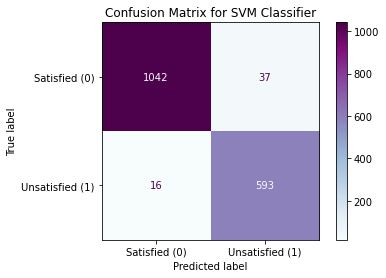

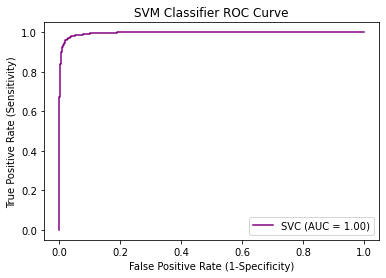

In [22]:
#create classification report
print (classification_report(y_test, SVM_predictions, labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
#create confusion matrix
display = pcm(SVM, X_test, y_test, display_labels=['Satisfied (0)', "Unsatisfied (1)"], cmap='BuPu')
display.ax_.set_title('Confusion Matrix for SVM Classifier')

#create ROC plot
plt = plot_roc_curve(SVM, X_test, y_test, color="purple")  
plt.ax_.set_title('SVM Classifier ROC Curve')
plt.ax_.set_xlabel('False Positive Rate (1-Specificity)')
plt.ax_.set_ylabel('True Positive Rate (Sensitivity)')

#other SVM classifier evaluations scores
print('SVM Accuracy:', (accuracy_score(y_test, SVM_predictions)))
print('SVM Jaccard:', (jaccard_score(y_test, SVM_predictions, pos_label=1, average='binary')))
print('SVM Log Loss:', (log_loss(y_test, SVM_prob)))

In [23]:
#apply Logistic Regression classifier to fit model on train dataset and predict on test dataset
logistic = LogisticRegression(dual=True, solver='liblinear')
logistic.fit(X_train, y_train)
logistic_predictions = logistic.predict(X_test)
logistic_prob = logistic.predict_proba(X_test)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9823    0.9778    0.9800      1079
Unsatisfied (1)     0.9609    0.9688    0.9648       609

       accuracy                         0.9745      1688
      macro avg     0.9716    0.9733    0.9724      1688
   weighted avg     0.9746    0.9745    0.9745      1688

Logistic Regression Accuracy: 0.9745260663507109
Logistic Regression Jaccard: 0.9320695102685624
Logistic Regression Log Loss: 0.08959535537500979


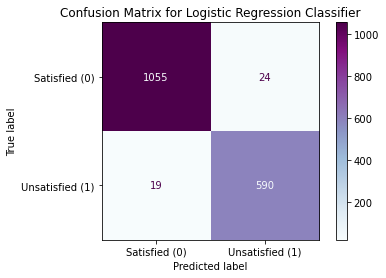

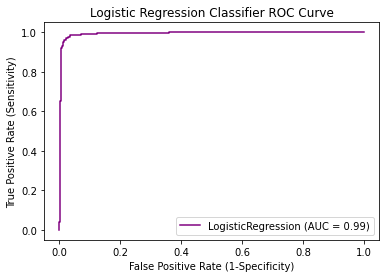

In [24]:
#create classification report
print (classification_report(y_test, logistic_predictions, labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
#create confusion matrix
display = pcm(logistic, X_test, y_test, display_labels=['Satisfied (0)', "Unsatisfied (1)"], cmap='BuPu')
display.ax_.set_title('Confusion Matrix for Logistic Regression Classifier')

#create ROC plot
plt = plot_roc_curve(logistic, X_test, y_test, color="purple")  
plt.ax_.set_title('Logistic Regression Classifier ROC Curve')
plt.ax_.set_xlabel('False Positive Rate (1-Specificity)')
plt.ax_.set_ylabel('True Positive Rate (Sensitivity)')

#other Logistic Regression classifier evaluation scores
print('Logistic Regression Accuracy:', (accuracy_score(y_test, logistic_predictions)))
print('Logistic Regression Jaccard:', (jaccard_score(y_test, logistic_predictions, pos_label=1, average='binary')))
print('Logistic Regression Log Loss:', (log_loss(y_test, logistic_prob)))

In [25]:
#apply Random Forest classifier to fit model on train dataset and predict on test dataset
random_forest = RandomForestClassifier(n_estimators=500, criterion="gini")
random_forest.fit(X_train, y_train)
random_forest_predictions = random_forest.predict(X_test)
random_forest_prob = random_forest.predict_proba(X_test)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9742    0.9815    0.9778      1079
Unsatisfied (1)     0.9667    0.9540    0.9603       609

       accuracy                         0.9716      1688
      macro avg     0.9705    0.9677    0.9691      1688
   weighted avg     0.9715    0.9716    0.9715      1688

Random Forest Accuracy: 0.9715639810426541
Random Forest Jaccard: 0.9236883942766295
Random Forest Log Loss: 0.17569962528968813


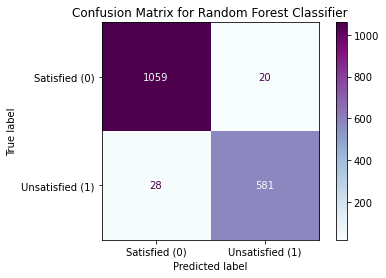

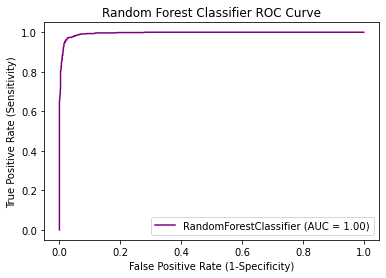

In [26]:
#create classification report
print (classification_report(y_test, random_forest_predictions, labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
#create confusion matrix
display = pcm(random_forest, X_test, y_test, display_labels=['Satisfied (0)', "Unsatisfied (1)"], cmap='BuPu')
display.ax_.set_title('Confusion Matrix for Random Forest Classifier')

#create ROC plot
plt = plot_roc_curve(random_forest, X_test, y_test, color="purple")  
plt.ax_.set_title('Random Forest Classifier ROC Curve')
plt.ax_.set_xlabel('False Positive Rate (1-Specificity)')
plt.ax_.set_ylabel('True Positive Rate (Sensitivity)')

#other Random Forest classifier evaluation scores 
print('Random Forest Accuracy:', (accuracy_score(y_test, random_forest_predictions)))
print('Random Forest Jaccard:', (jaccard_score(y_test, random_forest_predictions, pos_label=1, average='binary')))
print('Random Forest Log Loss:', (log_loss(y_test, random_forest_prob)))

In [27]:
#apply K-Nearest Neighbor classifier to fit model on train dataset and predict on test dataset
k_nearest = KNeighborsClassifier(n_neighbors=10)
k_nearest.fit(X_train, y_train)
k_nearest_predictions = k_nearest.predict(X_test)
k_nearest_prob = k_nearest.predict_proba(X_test)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9130    0.9045    0.9088      1079
Unsatisfied (1)     0.8336    0.8473    0.8404       609

       accuracy                         0.8839      1688
      macro avg     0.8733    0.8759    0.8746      1688
   weighted avg     0.8844    0.8839    0.8841      1688

K-Nearest-Neighbor Accuracy: 0.8838862559241706
K-Nearest-Neighbor Jaccard: 0.7247191011235955
K-Nearest-Neighbor Log Loss: 0.43755828261092455


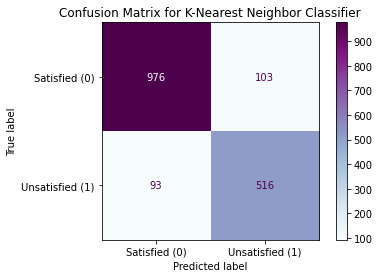

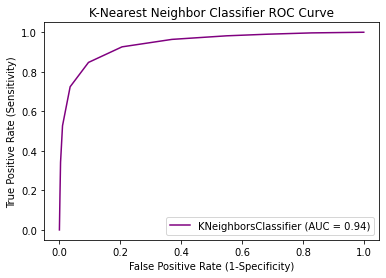

In [28]:
#create classification report
print (classification_report(y_test, k_nearest_predictions, labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
#create confusion matrix
display = pcm(k_nearest, X_test, y_test, display_labels=['Satisfied (0)', "Unsatisfied (1)"], cmap='BuPu')
display.ax_.set_title('Confusion Matrix for K-Nearest Neighbor Classifier')

#create ROC plot
plt = plot_roc_curve(k_nearest, X_test, y_test, color="purple")  
plt.ax_.set_title('K-Nearest Neighbor Classifier ROC Curve')
plt.ax_.set_xlabel('False Positive Rate (1-Specificity)')
plt.ax_.set_ylabel('True Positive Rate (Sensitivity)')

#other K-Nearest Neighbor evaluation scores 
print('K-Nearest-Neighbor Accuracy:', (accuracy_score(y_test, k_nearest_predictions)))
print('K-Nearest-Neighbor Jaccard:', (jaccard_score(y_test, k_nearest_predictions, pos_label=1, average='binary')))
print('K-Nearest-Neighbor Log Loss:', (log_loss(y_test, k_nearest_prob)))